# Vegetable Image Classification

## Exercise 1: Building a Convnet from Scratch

In this exercise, we will build a classifier model from scratch that is able to distinguish among 15 different types of vegetables. Similarly to our last lab, we will:

1. Explore the example data
2. Build a small convnet from scratch to solve our classification problem
3. Evaluate training and validation accuracy

Let's go!

## Explore the Example Data

Let's start by downloading our example data, a .zip of 21,000 JPG pictures of vegetables, and extracting it locally in `/tmp`. These data are replicated from the [Kaggle Vegetable Image Dataset](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset)

In [1]:
!if ! [ -f /tmp/vegetables.zip ]; then \
  wget --no-check-certificate \
    https://cdn.c18l.org/vegetables.zip \
    -O /tmp/vegetables.zip; \
fi

In [2]:
import os
import zipfile

local_zip = '/tmp/vegetables.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/Vegetable Images`, which contains `train`, `test`, and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain subdirectories for each of the image classes we'll be trying to predict. Let's define each of these directories:

In [3]:
from pathlib import Path

base_dir = Path('/tmp/Vegetable Images')
train_dir = base_dir / 'train'
test_dir = base_dir / 'test'
validation_dir = base_dir / 'validation'

image_classes = [x.name for x in train_dir.iterdir() if x.is_dir()]
image_classes

['Radish',
 'Bottle_Gourd',
 'Cucumber',
 'Brinjal',
 'Cauliflower',
 'Tomato',
 'Cabbage',
 'Pumpkin',
 'Papaya',
 'Bean',
 'Potato',
 'Broccoli',
 'Capsicum',
 'Carrot',
 'Bitter_Gourd']

Now, let's see what the filenames look like for some of our vegetables in a `train` subdirectory (file naming conventions are the same in the `test` and `validation` directory):

In [4]:
train_radish_fnames = os.listdir(train_dir / image_classes[0])
print(train_radish_fnames[:10])

test_radish_fnames = os.listdir(test_dir / image_classes[0])
print(test_radish_fnames[:10])

validation_radish_fnames = os.listdir(validation_dir / image_classes[0])
print(validation_radish_fnames[:10])

['0032.jpg', '0195.jpg', '0569.jpg', '0601.jpg', '0072.jpg', '0703.jpg', '0945.jpg', '0516.jpg', '0387.jpg', '0710.jpg']
['1083.jpg', '1035.jpg', '1154.jpg', '1147.jpg', '1164.jpg', '1170.jpg', '1045.jpg', '1088.jpg', '1078.jpg', '1119.jpg']
['1227.jpg', '1263.jpg', '1220.jpg', '1271.jpg', '1391.jpg', '1374.jpg', '1310.jpg', '1393.jpg', '1323.jpg', '1231.jpg']


Let's find out the total number of images in the `train` and `validation` directories:

In [5]:
print('total training radish images:', len(os.listdir(train_dir / image_classes[0])))
print('total testing radish images:', len(os.listdir(test_dir / image_classes[0])))
print('total validation radish images:', len(os.listdir(validation_dir / image_classes[0])))

total training radish images: 1000
total testing radish images: 200
total validation radish images: 200


For each image class, we have 1,000 training images, 200 test images, and 200 validation images.

Now let's take a look at a few pictures to get a better sense of what the dataset looks like. First, configure the matplot parameters:

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 radish pictures. You can rerun the cell to see a fresh batch each time:

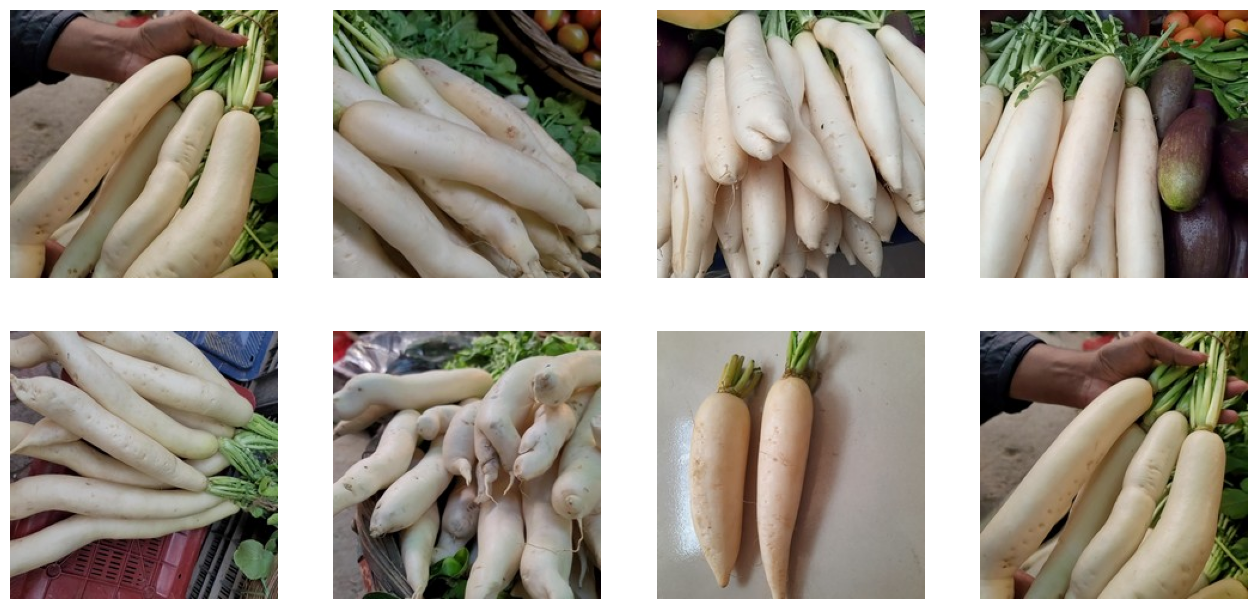

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_pix = [
    os.path.join(train_dir / image_classes[0], fname)
    for fname in train_radish_fnames[pic_index-8:pic_index]
]

for i, img_path in enumerate(next_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Building a Small Convnet from Scratch

In [ ]:
import tensorflow as tf


img_input = tf.keras.layers.Input(shape=(224, 224, 3))

x = tf.keras.layers.Conv2D(16, 3, activation='relu')(img_input)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

flatten = tf.keras.layers.Flatten()(x)

dense = tf.keras.layers.Dense(512, activation='relu')(flatten)
output = tf.keras.layers.Dense(15, activation='softmax')(dense)

In [9]:
model = tf.keras.Model(img_input, output)

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496 

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [13]:
%load_ext tensorboard

In [14]:
import os
import datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [15]:
%tensorboard --logdir logs

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=15,
    callbacks=[tensorboard_callback],
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/15


2023-11-09 16:51:52.021998: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-09 16:51:52.615104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-09 16:51:52.704105: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-09 16:51:52.840663: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2158047ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-09 16:51:52.840694: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-11-09 16:51:52.843677: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-09 16:51:52.884894: I ./tensorflow/compiler/jit/device_comp

200/200 [==============================] - ETA: 0s - loss: 2.3718 - categorical_accuracy: 0.2880

2023-11-09 16:51:55.114209: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5316280320 exceeds 10% of free system memory.


200/200 [==============================] - 4s 13ms/step - loss: 2.3718 - categorical_accuracy: 0.2880 - val_loss: 1.7805 - val_categorical_accuracy: 0.3360
Epoch 2/15
196/200 [============================>.] - ETA: 0s - loss: 1.5926 - categorical_accuracy: 0.4827

2023-11-09 16:51:57.528717: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5316280320 exceeds 10% of free system memory.


200/200 [==============================] - 2s 12ms/step - loss: 1.5878 - categorical_accuracy: 0.4810 - val_loss: 1.5681 - val_categorical_accuracy: 0.4800
Epoch 3/15
200/200 [==============================] - ETA: 0s - loss: 1.2654 - categorical_accuracy: 0.6050

2023-11-09 16:52:00.005789: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5316280320 exceeds 10% of free system memory.


200/200 [==============================] - 2s 12ms/step - loss: 1.2654 - categorical_accuracy: 0.6050 - val_loss: 0.9283 - val_categorical_accuracy: 0.7480
Epoch 4/15
198/200 [============================>.] - ETA: 0s - loss: 1.1108 - categorical_accuracy: 0.6495

2023-11-09 16:52:02.430160: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5316280320 exceeds 10% of free system memory.


200/200 [==============================] - 2s 12ms/step - loss: 1.1049 - categorical_accuracy: 0.6510 - val_loss: 0.9220 - val_categorical_accuracy: 0.7480
Epoch 5/15
194/200 [============================>.] - ETA: 0s - loss: 0.9158 - categorical_accuracy: 0.7330

2023-11-09 16:52:04.797023: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5316280320 exceeds 10% of free system memory.


200/200 [==============================] - 2s 12ms/step - loss: 0.8968 - categorical_accuracy: 0.7380 - val_loss: 1.1296 - val_categorical_accuracy: 0.6600
Epoch 6/15
200/200 [==============================] - 2s 12ms/step - loss: 0.7694 - categorical_accuracy: 0.7590 - val_loss: 0.6143 - val_categorical_accuracy: 0.8000
Epoch 7/15
200/200 [==============================] - 2s 12ms/step - loss: 0.6525 - categorical_accuracy: 0.8100 - val_loss: 0.8560 - val_categorical_accuracy: 0.7760
Epoch 8/15
200/200 [==============================] - 2s 12ms/step - loss: 0.6770 - categorical_accuracy: 0.8000 - val_loss: 0.6482 - val_categorical_accuracy: 0.7480
Epoch 9/15
200/200 [==============================] - 2s 12ms/step - loss: 0.6111 - categorical_accuracy: 0.8120 - val_loss: 0.6032 - val_categorical_accuracy: 0.8520
Epoch 10/15
200/200 [==============================] - 2s 12ms/step - loss: 0.5269 - categorical_accuracy: 0.8530 - val_loss: 0.5853 - val_categorical_accuracy: 0.8600
Epoch 11